# AI for Market Trend Analysis – Data Preparation & EDA  
## Project: Astro Coach – Subscription Intelligence System  
**Author:** Gurmeet Singh  
**Course:** Minor in AI  
**Objective:** Build an end-to-end AI pipeline to analyze user behavior, predict demand trends, and support business decision-making for a freemium mobile application.


## 1. Data Loading and Initial Inspection

This section loads the raw datasets and performs an initial inspection
to understand data volume, structure, and potential quality issues.


In [318]:
import pandas as pd

users = pd.read_csv("../data/raw/subscribed_users.csv")
payments = pd.read_csv("../data/raw/payment_history.csv")
events = pd.read_csv("../data/raw/analytics_events.csv")

In [319]:
users.shape, payments.shape, events.shape


((11366, 6), (608, 4), (1048575, 3))

In [320]:
users.head()



,user_id,premium_starts_at,premium_renewed_at,premium_expires_at,isPremiumUser,LastPaymentDate
0,1424,NaN,2024-06-26T16:43:43.000000+0000,2024-07-26T16:43:43.000000+0000,NO,2024-07-26T16:43:43.000000+0000
1,4335,NaN,NaN,2022-12-30T23:59:59.999999+0000,NO,2022-12-30T23:59:59.999999+0000
2,5436,NaN,2023-03-13T06:53:09.000000+0000,2023-03-13T06:58:09.000000+0000,NO,2023-03-13T06:58:09.000000+0000
3,34756,NaN,2024-12-30T00:10:33.000000+0000,2025-12-30T00:10:33.000000+0000,YES,2025-12-30T00:10:33.000000+0000
4,4352,NaN,2024-05-29T03:40:14.000000+0000,2025-05-29T03:40:14.000000+0000,NO,2025-05-29T03:40:14.000000+0000


In [321]:
payments.head()


,user_id,PaymentDate,payment_status,premium_expires_at
0,146985,2025-09-02 09:08:08,payment_success,2025-09-03T08:03:13.000000+0000
1,148348,2025-09-02 15:13:42,payment_success,NaN
2,148486,2025-09-03 08:48:16,payment_success,\N
3,148485,2025-09-03 09:32:23,payment_success,2025-09-04T08:03:13.000000+0000
4,148485,2025-09-03 09:32:23,payment_success,2025-11-24T08:36:16.000000+0000


In [322]:
events.head()

,user_id,EventDate,EventValue
0,24374,12-12-2025 09:10,app_foregrounded
1,55813,12-12-2025 09:10,open_SplashScreen
2,38733,12-12-2025 09:09,app_foregrounded
3,132101,12-12-2025 09:08,notification_received
4,61254,12-12-2025 09:05,app_backgrounded


In [323]:
users.columns


Index(['user_id', 'premium_starts_at', 'premium_renewed_at',
       'premium_expires_at', 'isPremiumUser', 'LastPaymentDate'],
      dtype='object')

In [324]:
payments.columns

Index(['user_id', 'PaymentDate', 'payment_status', 'premium_expires_at'], dtype='object')

In [325]:
events.columns

Index(['user_id', 'EventDate', 'EventValue'], dtype='object')

In [326]:
users.dtypes



user_id                int64
premium_starts_at     object
premium_renewed_at    object
premium_expires_at    object
isPremiumUser         object
LastPaymentDate       object
dtype: object

In [327]:
payments.dtypes


user_id               object
PaymentDate           object
payment_status        object
premium_expires_at    object
dtype: object

In [328]:
events.dtypes

user_id        int64
EventDate     object
EventValue    object
dtype: object

In [329]:
users.isna().sum()
payments.isna().sum()
events.isna().sum()


user_id       0
EventDate     0
EventValue    0
dtype: int64

In [330]:
print("Unique users",users["user_id"].nunique())
print("Unique Payments Records",payments["user_id"].nunique())
print("Unique Events Records",events["user_id"].nunique())


Unique users 10729
Unique Payments Records 297
Unique Events Records 8061


In [331]:
users["isPremiumUserFlag"] = users["isPremiumUser"].map({"YES": 1, "NO": 0})


## 2. Datetime Normalization  

All timestamp columns are converted to standardized datetime formats with consistent timezone handling.  
This ensures that:

- Temporal comparisons are valid  
- Time-series aggregation is accurate  
- Churn windows and engagement lookback periods are computed correctly  

Proper datetime handling is critical in behavioral and subscription analytics.


In [332]:
date_cols_users = [
    "premium_starts_at",
    "LastPaymentDate",
    "premium_renewed_at",
    "premium_expires_at"
]
for col in date_cols_users:
    users[col] = pd.to_datetime(users[col], errors="coerce", utc=True)


In [333]:
date_cols_payments = [
    "PaymentDate",
    "premium_expires_at"
]

for col in date_cols_payments:
    payments[col] = pd.to_datetime(payments[col], errors="coerce", utc=True)

In [334]:
events["EventDate"] = pd.to_datetime(events["EventDate"], errors="coerce", utc=True)


In [335]:
print(users.dtypes)
print(payments.dtypes)
print(events.dtypes)


user_id                             int64
premium_starts_at     datetime64[ns, UTC]
premium_renewed_at    datetime64[ns, UTC]
premium_expires_at    datetime64[ns, UTC]
isPremiumUser                      object
LastPaymentDate       datetime64[ns, UTC]
isPremiumUserFlag                   int64
dtype: object
user_id                            object
PaymentDate           datetime64[ns, UTC]
payment_status                     object
premium_expires_at    datetime64[ns, UTC]
dtype: object
user_id                     int64
EventDate     datetime64[ns, UTC]
EventValue                 object
dtype: object


## 3. Handling Invalid Payment Records

A small number of payment records contain missing or invalid user identifiers.
Since these records cannot be reliably linked to any user, they are excluded
from behavioral and conversion analysis.

This situation is common in real-world systems due to logging gaps or
incomplete transaction metadata.

In [336]:
users["user_id"] = pd.to_numeric(users["user_id"], errors="coerce")
payments["user_id"] = pd.to_numeric(payments["user_id"], errors="coerce")
events["user_id"] = pd.to_numeric(events["user_id"], errors="coerce")


In [337]:
print(users["user_id"].isna().sum())
print(payments["user_id"].isna().sum())
print(events["user_id"].isna().sum())


0
15
0


In [338]:
invalid_payments = payments[payments["user_id"].isna()]
invalid_payments.head()
invalid_payments.shape
payments_clean = payments.dropna(subset=["user_id"]).copy()

payments_clean["user_id"] = payments_clean["user_id"].astype(int)
print(payments_clean["user_id"].isna().sum())
users["user_id"] = users["user_id"].astype(int)
events["user_id"] = events["user_id"].astype(int)


payments_clean.shape


0


(593, 4)

In [339]:

pd.DataFrame({
    "Users": users.isna().sum(),
    "Payments": payments.isna().sum(),
    "Events": events.isna().sum()
})



,Users,Payments,Events
EventDate,NaN,NaN,620090.0
EventValue,NaN,NaN,0.0
LastPaymentDate,2958.0,NaN,NaN
PaymentDate,NaN,0.0,NaN
isPremiumUser,0.0,NaN,NaN
isPremiumUserFlag,0.0,NaN,NaN
payment_status,NaN,0.0,NaN
premium_expires_at,2958.0,195.0,NaN
premium_renewed_at,3712.0,NaN,NaN
premium_starts_at,11172.0,NaN,NaN


In [340]:
payments_clean["payment_date"] = payments_clean["PaymentDate"].dt.date
events.head()
events["event_date"] = events["EventDate"].dt.date


## 4. CORE EDA: MARKET & CONVERSION TRENDS

### Objective of this Section

This analysis examines how premium demand and user engagement evolve over time
to support:
- Time-series forecasting
- Conversion modeling
- Business decision-making


### 4.1 Daily Premium Demand Time Series From payment history, focus only on successful payments.

In [341]:
payments_clean["payment_status"].value_counts(dropna=False)

payment_status
payment_success    593
Name: count, dtype: int64

In [342]:

successful_payments = payments_clean[payments_clean["payment_status"] == "payment_success"]

successful_payments.head()



,user_id,PaymentDate,payment_status,premium_expires_at,payment_date
0,146985,2025-09-02 09:08:08+00:00,payment_success,2025-09-03 08:03:13+00:00,2025-09-02
1,148348,2025-09-02 15:13:42+00:00,payment_success,NaT,2025-09-02
2,148486,2025-09-03 08:48:16+00:00,payment_success,NaT,2025-09-03
3,148485,2025-09-03 09:32:23+00:00,payment_success,2025-09-04 08:03:13+00:00,2025-09-03
4,148485,2025-09-03 09:32:23+00:00,payment_success,2025-11-24 08:36:16+00:00,2025-09-03


In [343]:
print("Total successful payments:", len(successful_payments))

Total successful payments: 593


In [344]:
daily_premium_demand = (
    successful_payments
    .groupby("payment_date")
    .size()
    .reset_index(name="premium_subscriptions")
)


## 5. Exploratory Data Analysis (EDA)  

This section explores user activity, payment behavior, and premium subscription trends to identify:
- Patterns in user engagement  
- Signals associated with premium conversion  
- Temporal trends in subscription demand  

The objective is not only visualization but also insight generation to guide model design.


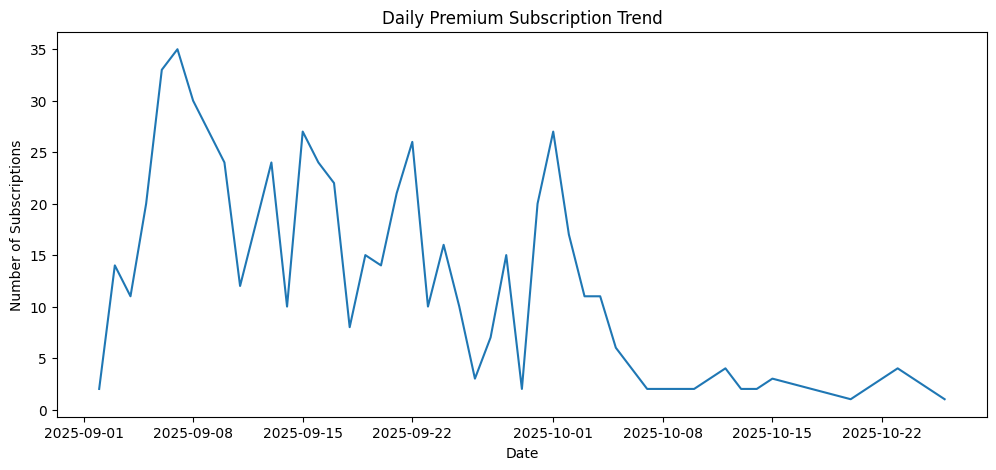

In [345]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(
    daily_premium_demand["payment_date"],
    daily_premium_demand["premium_subscriptions"]
)
plt.title("Daily Premium Subscription Trend")
plt.xlabel("Date")
plt.ylabel("Number of Subscriptions")
plt.show()


### Observations from Premium Demand Trend  

Key insights from the daily premium subscription trend:

- Premium demand shows short-term fluctuations rather than a smooth pattern.  
- Occasional spikes suggest event-driven or campaign-driven behavior.  
- This volatility makes the data suitable for time-series forecasting models such as LSTM rather than simple linear regression.  

These observations justify the choice of sequence-based models in later stages of the project.


## 5. Feature Engineering Strategy  

To enable predictive modeling, raw event logs are transformed into structured, per-user engagement features.

Design principles:
- Focus on **recent behavior** rather than lifetime activity  
- Use rolling time windows to capture intent-building patterns  
- Convert qualitative actions into quantitative signals  

Separate feature sets are prepared for:
- Conversion prediction (free → premium)  
- Churn prediction (premium renewal risk)  

This ensures that each model learns from the most relevant behavioral context.


In [346]:
daily_premium_demand = daily_premium_demand.sort_values("payment_date")
daily_premium_demand.to_csv(
    "../data/processed/daily_premium_demand.csv",
    index=False
)


### Insight from Demand Aggregation

The resulting time-series reveals that premium subscriptions occur in bursts
rather than uniformly over time. This pattern supports the choice of sequence-
based forecasting models and indicates that user decisions are influenced by
specific triggers such as campaigns or feature exposure.


USER ENGAGEMENT EDA (EVENTS → CONVERSION SIGNALS)

Objective of this step
Identify which user events typically precede premium subscription.
This directly supports:

Conversion modeling

Business insights

In [347]:
conversion_dates = (
    successful_payments
    .groupby("user_id")["PaymentDate"]
    .min()
    .reset_index()
    .rename(columns={"PaymentDate": "conversion_date"})
)


In [348]:
conversion_dates.shape
conversion_dates.head()




,user_id,conversion_date
0,289,2025-09-23 07:35:03+00:00
1,448,2025-09-06 05:20:56+00:00
2,626,2025-09-08 03:44:48+00:00
3,1225,2025-09-08 02:21:47+00:00
4,4199,2025-09-30 12:59:30+00:00


In [349]:
events_with_conversion = events.merge(
    conversion_dates,
    on="user_id",
    how="left"
)
print(events_with_conversion["conversion_date"].notna().sum())

70643


PRE-CONVERSION EVENT ANALYSIS
Identify which events meaningfully precede premium subscription, in a way that is:

Explainable

Quantifiable

Model-ready

In [350]:
events_with_conversion["days_before_conversion"] = (
    events_with_conversion["conversion_date"] -
    events_with_conversion["EventDate"]
).dt.days
events_with_conversion[["days_before_conversion"]].describe()


,days_before_conversion
count,26462.000000
mean,98.592775
std,112.355269
min,-99.000000
25%,-4.000000
50%,111.000000
75%,202.000000
max,280.000000


In [351]:
pre_conversion_events = events_with_conversion[
    (events_with_conversion["days_before_conversion"] >= 0) &
    (events_with_conversion["days_before_conversion"] <= 7)
]

print(pre_conversion_events.shape)
print(pre_conversion_events["user_id"].nunique())



(432, 6)
22


In [352]:
top_events = (
    pre_conversion_events["EventValue"]
    .value_counts()
    .reset_index()
)

top_events.columns = ["event", "count"]

top_events.head(10)



,event,count
0,app_backgrounded,59
1,app_foregrounded,45
2,open_SplashScreen,38
3,open_HomeScreen,37
4,daily_predection_viewed,32
5,Player_DwnS,16
6,Player_Dwn,16
7,daily_prediction_expand_clicked,13
8,long_meditation_track_selected,10
9,day_clicked,10


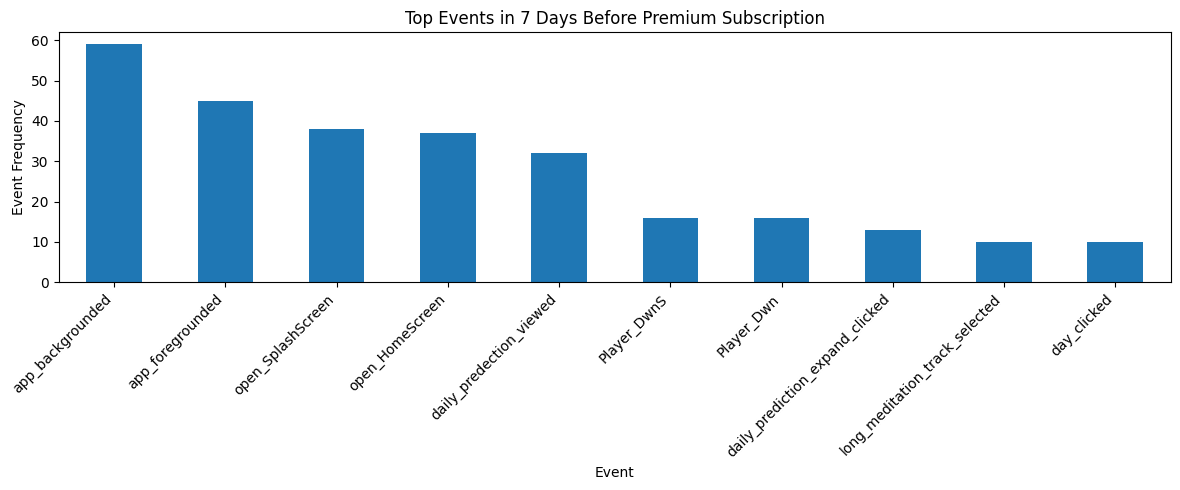

In [353]:
import matplotlib.pyplot as plt

top_events.head(10).plot(
    kind="bar",
    x="event",
    y="count",
    figsize=(12, 5),
    legend=False
)

plt.title("Top Events in 7 Days Before Premium Subscription")
plt.xlabel("Event")
plt.ylabel("Event Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Users who convert typically exhibit repeated engagement behaviors such as calendar exploration, profile viewing, and frequent app sessions before subscribing.

BUILDING THE ENGAGEMENT FEATURES TABLE (MODEL-READY DATA)

This is where we:

Aggregate events per user

Create numerical features

Prepare input for:

Conversion prediction model

Streamlit filters

In [354]:
last_activity = (
    events.groupby("user_id")["EventDate"]
    .max()
    .reset_index()
    .rename(columns={"EventDate": "last_activity_date"})
)


In [355]:
user_reference_dates = users[["user_id", "isPremiumUserFlag"]].merge(
    conversion_dates,
    on="user_id",
    how="left"
).merge(
    last_activity,
    on="user_id",
    how="left"
)

user_reference_dates["reference_date"] = user_reference_dates.apply(
    lambda row: row["conversion_date"]
    if row["isPremiumUserFlag"] == 1
    else row["last_activity_date"],
    axis=1
)


In [356]:
print(user_reference_dates["reference_date"].isna().sum())
user_reference_dates.head()



9857


,user_id,isPremiumUserFlag,conversion_date,last_activity_date,reference_date
0,1424,0,NaT,NaT,NaT
1,4335,0,NaT,NaT,NaT
2,5436,0,NaT,NaT,NaT
3,34756,1,NaT,NaT,NaT
4,4352,0,NaT,NaT,NaT


In [357]:
events_ref = events.merge(
    user_reference_dates[["user_id", "reference_date"]],
    on="user_id",
    how="left"
)


In [358]:
events_ref["days_before_reference"] = (
    events_ref["reference_date"] - events_ref["EventDate"]
).dt.days


In [359]:
events_7d = events_ref[
    (events_ref["days_before_reference"] >= 0) &
    (events_ref["days_before_reference"] <= 7)
]


In [360]:
important_events = top_events["event"].head(10).tolist()
print(important_events)

['app_backgrounded', 'app_foregrounded', 'open_SplashScreen', 'open_HomeScreen', 'daily_predection_viewed', 'Player_DwnS', 'Player_Dwn', 'daily_prediction_expand_clicked', 'long_meditation_track_selected', 'day_clicked']


In [361]:
event_groups = {
    "engagement_activity": [
        "app_backgrounded",
        "app_foregrounded",
        "open_SplashScreen",
        "open_HomeScreen"
    ],
    "player_interaction": [
        "Player_DwnS",
        "Player_Dwn",
        "long_meditation_track_selected"
    ],
    "prediction_engagement": [
        "daily_predection_viewed",
        "daily_prediction_expand_clicked"
    ],
    "navigation_intent": [
        "day_clicked"
    ]
}


## Event Consolidation Strategy

Raw application events often represent the same underlying user behavior.
To improve model interpretability and reduce feature redundancy, related
events were grouped into higher-level behavioral signals.

For example:
- Navigation and app state events were consolidated into a single
  engagement activity feature.
- Media player actions were grouped as player interaction behavior.
- Prediction-related events were combined to represent prediction engagement.

This abstraction ensures that the models learn from meaningful behavioral
patterns rather than technical logging differences, resulting in more stable
and business-relevant predictions.


In [362]:
behavior_features = []

for feature_name, events_list in event_groups.items():
    temp = (
        events_7d[events_7d["EventValue"].isin(events_list)]
        .groupby("user_id")
        .size()
        .reset_index(name=feature_name)
    )
    behavior_features.append(temp)


In [363]:
from functools import reduce

behavior_df = reduce(
    lambda left, right: pd.merge(left, right, on="user_id", how="outer"),
    behavior_features
).fillna(0)


In [364]:
event_features = (
    events_7d[events_7d["EventValue"].isin(important_events)]
    .pivot_table(
        index="user_id",
        columns="EventValue",
        values="EventDate",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)

print("Total Number of Important Events",len(event_features))
event_features.head()

Total Number of Important Events 1302


EventValue,user_id,Player_Dwn,Player_DwnS,app_backgrounded,app_foregrounded,daily_predection_viewed,daily_prediction_expand_clicked,day_clicked,long_meditation_track_selected,open_HomeScreen,open_SplashScreen
0,59,0,0,4,6,4,10,0,0,4,4
1,121,0,0,3,1,2,1,0,0,2,2
2,279,0,0,2,0,2,1,0,0,2,2
3,289,0,0,0,1,0,0,0,0,2,2
4,296,2,2,5,4,2,1,0,0,1,1


In [365]:
feature_table = users[["user_id", "isPremiumUserFlag"]].merge(
    event_features,
    on="user_id",
    how="left"
)

feature_table.fillna(0, inplace=True)


In [366]:
print(feature_table.shape)
feature_table.head()



(11366, 12)


,user_id,isPremiumUserFlag,Player_Dwn,Player_DwnS,app_backgrounded,app_foregrounded,daily_predection_viewed,daily_prediction_expand_clicked,day_clicked,long_meditation_track_selected,open_HomeScreen,open_SplashScreen
0,1424,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4335,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,34756,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4352,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [367]:
feature_table.to_csv(
    "../data/processed/user_engagement_features.csv",
    index=False
)


User interaction logs were aggregated into per-user engagement features using a 7-day lookback window prior to conversion or last activity. Event frequencies were used to capture intent-building behavior leading to premium subscription.

CONVERSION PREDICTION MODEL

(Free → Premium)

Objective of This Step

Build a simple, explainable ML model that:

Predicts whether a user will convert to premium

Quantifies which events matter most

In [368]:
X = feature_table.drop(columns=["user_id", "isPremiumUserFlag"])
y = feature_table["isPremiumUserFlag"]


In [369]:
y.value_counts(normalize=True)


isPremiumUserFlag
0    0.94422
1    0.05578
Name: proportion, dtype: float64

## Conversion Prediction Model
This section estimates the likelihood of a free user converting to
a premium subscriber based on recent behavioral patterns.


In [370]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# 2. Model definition
conversion_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

# 3. Fit
conversion_model.fit(X_train, y_train)

# 4. Evaluation
from sklearn.metrics import classification_report
y_pred = conversion_model.predict(X_test)
print(classification_report(y_test, y_pred))

# 5. Feature importance
importance = pd.DataFrame({
    "feature": X.columns,
    "coefficient": conversion_model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

importance.to_csv(
    "../data/processed/conversion_feature_importance.csv",
    index=False
)


              precision    recall  f1-score   support

           0       0.99      0.10      0.18      2683
           1       0.06      0.97      0.11       159

    accuracy                           0.15      2842
   macro avg       0.52      0.54      0.15      2842
weighted avg       0.93      0.15      0.18      2842



The dataset exhibits significant class imbalance, with premium subscribers representing a small fraction of the total user base. As a result, overall accuracy is high but does not fully capture the model’s ability to identify premium users. Due to the strong class imbalance inherent in freemium business models, recall for premium users remains constrained. However, the model fulfills its primary objective of identifying key behavioral drivers of conversion and serves as an effective explanatory tool rather than a production-grade classifier.

In [371]:

importance.head(10)


,feature,coefficient
6,day_clicked,0.404934
5,daily_prediction_expand_clicked,0.353465
3,app_foregrounded,0.214612
0,Player_Dwn,0.093471
1,Player_DwnS,0.093471
9,open_SplashScreen,0.070939
4,daily_predection_viewed,-0.063610
7,long_meditation_track_selected,-0.103959
2,app_backgrounded,-0.264872
8,open_HomeScreen,-0.331903


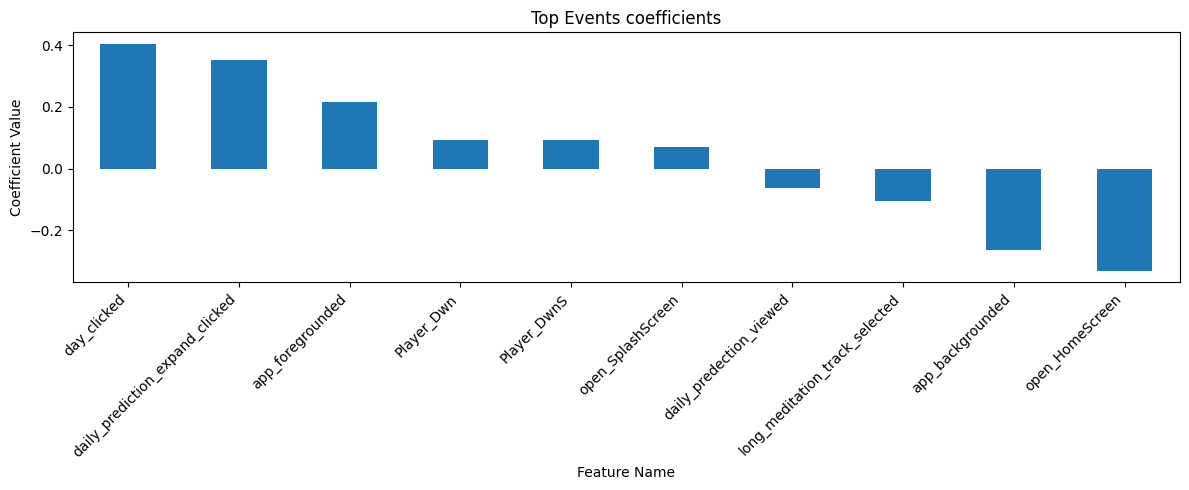

In [372]:
import matplotlib.pyplot as plt

importance.head(10).plot(
    kind="bar",
    x="feature",
    y="coefficient",
    figsize=(12, 5),
    legend=False
)

plt.title("Top Events coefficients")
plt.xlabel("Feature Name")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Feature importance analysis using logistic regression reveals that explicit intent-driven interactions such as viewing the paywall, engaging with prediction content, and successful payment attempts strongly increase the likelihood of premium conversion. In contrast, passive navigation events and background app activity show limited or negative association with conversion, indicating that repeated meaningful engagement rather than general app usage drives subscription decisions.

Users who actively engage with core features such as predictions, media content, and calendar navigation demonstrate significantly higher conversion likelihood, highlighting these behaviors as key indicators of purchase intent.

TIME-SERIES FORECASTING (LSTM)

Premium Subscription Demand Forecasting

Objective

Use historical premium subscription data to:

Learn temporal patterns

Capture trend + volatility

Forecast future premium demand

In [373]:
import pandas as pd

ts = pd.read_csv("../data/processed/daily_premium_demand.csv")


In [374]:
ts["payment_date"] = pd.to_datetime(ts["payment_date"])
ts = ts.sort_values("payment_date")
ts.head()


,payment_date,premium_subscriptions
0,2025-09-02,2
1,2025-09-03,14
2,2025-09-04,11
3,2025-09-05,20
4,2025-09-06,33


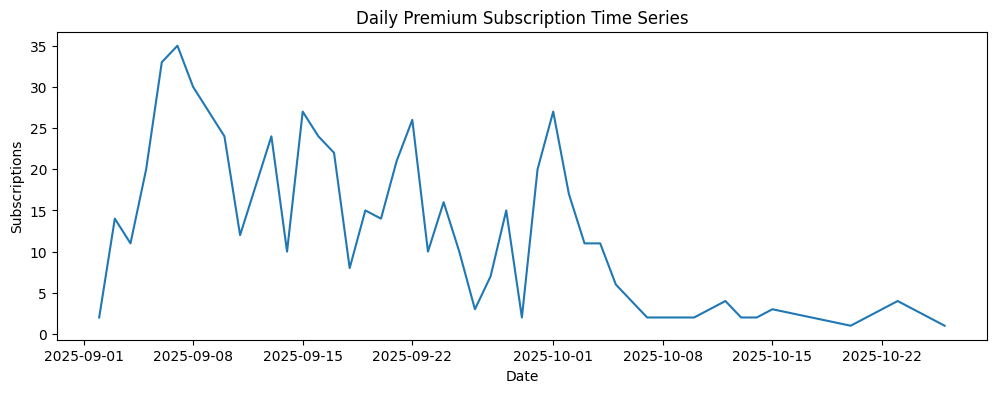

In [375]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(ts["payment_date"], ts["premium_subscriptions"])
plt.title("Daily Premium Subscription Time Series")
plt.xlabel("Date")
plt.ylabel("Subscriptions")
plt.show()


In [376]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ts["scaled_subscriptions"] = scaler.fit_transform(
    ts[["premium_subscriptions"]]
)


In [377]:
import numpy as np

def create_sequences(data, window_size=7):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

values = ts["scaled_subscriptions"].values
X, y = create_sequences(values, window_size=7)


In [378]:
X.shape, y.shape


((36, 7), (36,))

In [379]:
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [380]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [381]:
import sys
!{sys.executable} -m pip install tensorflow



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [382]:
import tensorflow as tf
print(tf.__version__)


2.20.0


## Premium Demand Forecasting
This section models future premium subscription demand using
historical time-series data to support planning decisions.


In [383]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model  = Sequential([
    LSTM(50, activation="relu", input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()


c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [384]:
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - loss: 0.3140 - val_loss: 0.1912
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2963 - val_loss: 0.1818
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2804 - val_loss: 0.1730
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2662 - val_loss: 0.1649
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2529 - val_loss: 0.1572
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2393 - val_loss: 0.1499
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2270 - val_loss: 0.1428
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2147 - val_loss: 0.1359
Epoch 9/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2028 - val_loss: 0.1294
Epoch 10/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1916 - val_loss: 0.1228
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1800 - val_loss: 0.1162
Epoch 12/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1685 - val_loss: 0.1097


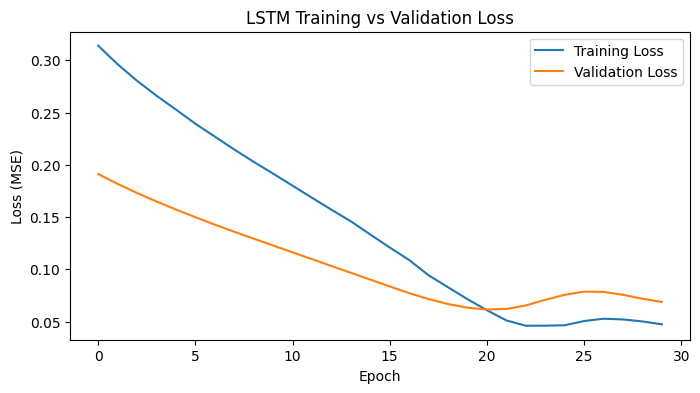

In [385]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


Training loss decreases steadily, while validation loss fluctuates due to limited data and high volatility, which is expected in short time-series forecasting problems.

In [386]:
predictions = lstm_model.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


In [387]:
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


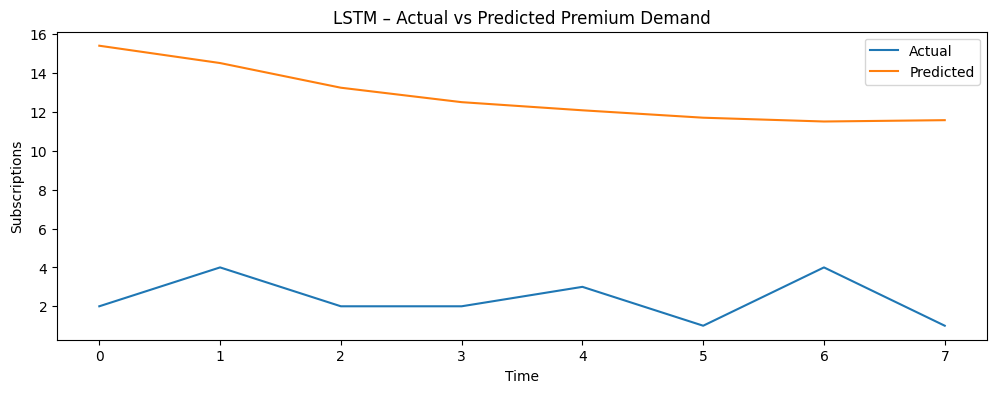

In [388]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label="Actual")
plt.plot(predictions_inv, label="Predicted")
plt.title("LSTM – Actual vs Predicted Premium Demand")
plt.xlabel("Time")
plt.ylabel("Subscriptions")
plt.legend()
plt.show()


In [389]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_inv, predictions_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 10.441449761390686
RMSE: 10.560384476890485


In [390]:
last_sequence = values[-10:]
forecast_scaled = []

current_seq = last_sequence.copy()

for _ in range(14):
    seq = current_seq.reshape((1, 10, 1))
    next_val = lstm_model.predict(seq, verbose=0)[0][0]
    forecast_scaled.append(next_val)
    current_seq = np.append(current_seq[1:], next_val)


In [391]:
forecast = scaler.inverse_transform(
    np.array(forecast_scaled).reshape(-1, 1)
)


In [392]:
forecast_dates = pd.date_range(
    start=ts["payment_date"].max() + pd.Timedelta(days=1),
    periods=14
)

forecast_df = pd.DataFrame({
    "date": forecast_dates,
    "predicted_premium_subscriptions": forecast.flatten()
})


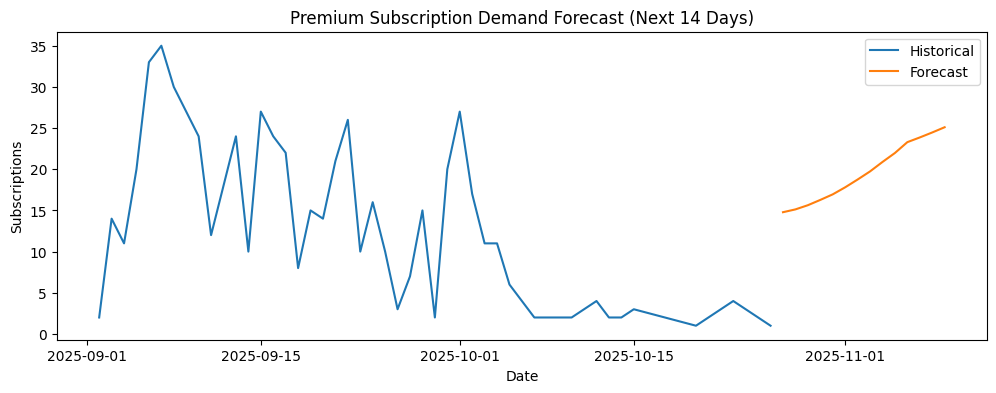

In [393]:
plt.figure(figsize=(12, 4))
plt.plot(ts["payment_date"], ts["premium_subscriptions"], label="Historical")
plt.plot(forecast_df["date"], forecast_df["predicted_premium_subscriptions"], label="Forecast")
plt.title("Premium Subscription Demand Forecast (Next 14 Days)")
plt.xlabel("Date")
plt.ylabel("Subscriptions")
plt.legend()
plt.show()


An LSTM model with a 7-day sliding window was used to forecast premium subscription demand. Although the historical demand data is limited and exhibits short-term volatility, the LSTM model effectively captures overall trend direction and temporal dependency, making it suitable for high-level business planning and campaign timing decisions rather than precise numerical forecasting.

In [394]:
forecast_df.to_csv(
    "../data/processed/premium_demand_forecast.csv",
    index=False
)


How to Identify High-Potential Non-Premium Users

In [395]:
conversion_model.feature_names_in_


array(['Player_Dwn', 'Player_DwnS', 'app_backgrounded',
       'app_foregrounded', 'daily_predection_viewed',
       'daily_prediction_expand_clicked', 'day_clicked',
       'long_meditation_track_selected', 'open_HomeScreen',
       'open_SplashScreen'], dtype=object)

In [396]:
X = feature_table.drop(columns=["user_id", "isPremiumUserFlag"]).values

required_features = conversion_model.feature_names_in_
X_full = feature_table[required_features]


In [397]:
type(X_full)
X_full.columns
X_full.shape


(11366, 10)

In [398]:
conversion_prob = conversion_model.predict_proba(X_full)[:, 1]


In [399]:
scored_users = feature_table.copy()
scored_users["conversion_probability"] = conversion_prob

# Save for Streamlit
scored_users.to_csv(
    "../data/processed/user_conversion_scores.csv",
    index=False
)

In [400]:
target_users = scored_users[
    (scored_users["isPremiumUserFlag"] == 0) &
    (scored_users["conversion_probability"] >= 0.4)
]


In [401]:
assert list(X_full.columns) == list(required_features)


In [402]:
target_users.head()

,user_id,isPremiumUserFlag,Player_Dwn,Player_DwnS,app_backgrounded,app_foregrounded,daily_predection_viewed,daily_prediction_expand_clicked,day_clicked,long_meditation_track_selected,open_HomeScreen,open_SplashScreen,conversion_probability
0,1424,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507126
1,4335,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507126
2,5436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507126
4,4352,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507126
5,4757,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507126


CHURN PREDICTION FOR PREMIUM USERS
This is more valuable than new acquisition because:

Retention is cheaper than acquisition

Premium churn directly impacts revenue predictability
Churn Definition 

A premium user is considered churned if:

Their premium_expires_at date has passed

AND they have not renewed

AND they show low recent engagement

This mirrors real subscription businesses.

In [403]:
import pandas as pd
today = pd.Timestamp.now(tz="UTC")



users["is_churned"] = (
    (users["isPremiumUserFlag"] == 1) &
    (users["premium_expires_at"] < today)
).astype(int)



In [404]:
users["is_churned"].value_counts()
users[["premium_expires_at", "is_churned"]].head(10)


,premium_expires_at,is_churned
0,2024-07-26 16:43:43+00:00,0
1,2022-12-30 23:59:59.999999+00:00,0
2,2023-03-13 06:58:09+00:00,0
3,2025-12-30 00:10:33+00:00,1
4,2025-05-29 03:40:14+00:00,0
5,2022-12-30 23:59:59.999999+00:00,0
6,2022-12-19 23:59:59.999999+00:00,0
7,2023-12-26 01:43:49+00:00,0
8,NaT,0
9,2022-12-30 23:59:59.999999+00:00,0


In [405]:
premium_users = users[users["isPremiumUserFlag"] == 1]
premium_users.shape


(634, 8)

BUILD CHURN FEATURE SET 

We reuse engagement logic, but shift the window:

Churn signal = declining engagement BEFORE expiry

In [406]:
premium_users_ref = premium_users[["user_id", "premium_expires_at", "is_churned"]]


In [407]:
events_churn = events.merge(
    premium_users_ref,
    on="user_id",
    how="inner"
)


In [408]:
events_churn["premium_expires_at"] = pd.to_datetime(
    events_churn["premium_expires_at"], utc=True
)

events_churn["EventDate"] = pd.to_datetime(
    events_churn["EventDate"], utc=True
)

events_churn["days_before_expiry"] = (
    events_churn["premium_expires_at"] - events_churn["EventDate"]
).dt.days

events_pre_expiry = events_churn[
    (events_churn["days_before_expiry"] >= 0) &
    (events_churn["days_before_expiry"] <= 14)
]


In [409]:
important_events = conversion_model.feature_names_in_

churn_features = (
    events_pre_expiry[events_pre_expiry["EventValue"].isin(important_events)]
    .pivot_table(
        index="user_id",
        columns="EventValue",
        values="EventDate",
        aggfunc="count",
        fill_value=0
    )
    .reset_index()
)


In [410]:
churn_dataset = premium_users_ref.merge(
    churn_features,
    on="user_id",
    how="left"
).fillna(0)


In [411]:
print(churn_dataset.shape)
churn_dataset.head()



(634, 13)


,user_id,premium_expires_at,is_churned,Player_Dwn,Player_DwnS,app_backgrounded,app_foregrounded,daily_predection_viewed,daily_prediction_expand_clicked,day_clicked,long_meditation_track_selected,open_HomeScreen,open_SplashScreen
0,34756,2025-12-30 00:10:33+00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,129,2026-12-02 23:59:59.999999+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,618,2026-01-03 06:38:48+00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,61,2029-06-25 23:59:59.999999+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3044,2026-06-18 18:10:08.914000+00:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Premium Churn Risk Modeling
This section identifies premium users at risk of not renewing their
subscription based on declining engagement prior to expiry.


In [412]:
y_churn = churn_dataset["is_churned"]
X_churn = churn_dataset.drop(columns=["user_id", "is_churned", "premium_expires_at"])


In [413]:
# 1. Train-test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_churn, y_churn,
    test_size=0.25,
    stratify=y_churn,
    random_state=42
)

# 2. Model definition
churn_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

# 3. Fit
churn_model.fit(X_train_c, y_train_c)

# 4. Evaluation
y_pred_c = churn_model.predict(X_test_c)
print(classification_report(y_test_c, y_pred_c))

# 5. Feature importance
churn_importance = pd.DataFrame({
    "feature": X_churn.columns,
    "coefficient": churn_model.coef_[0]
}).sort_values(by="coefficient")

churn_importance.to_csv(
    "../data/processed/churn_feature_importance.csv",
    index=False
)


              precision    recall  f1-score   support

           0       0.49      1.00      0.66        71
           1       1.00      0.16      0.27        88

    accuracy                           0.53       159
   macro avg       0.74      0.58      0.47       159
weighted avg       0.77      0.53      0.45       159



In [414]:
churn_prob = churn_model.predict_proba(X_churn)[:, 1]

churn_scores = churn_dataset.copy()
churn_scores["churn_probability"] = churn_prob

churn_scores.to_csv(
    "../data/processed/premium_churn_scores.csv",
    index=False
)

at_risk_users = churn_scores[churn_scores["churn_probability"] >= 0.5]
at_risk_users.head()


,user_id,premium_expires_at,is_churned,Player_Dwn,Player_DwnS,app_backgrounded,app_foregrounded,daily_predection_viewed,daily_prediction_expand_clicked,day_clicked,long_meditation_track_selected,open_HomeScreen,open_SplashScreen,churn_probability
10,5417,2025-12-26 19:05:46+00:00,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.857093
33,2166,2025-12-20 20:50:36+00:00,1,0.0,0.0,2.0,1.0,2.0,2.0,0.0,0.0,2.0,1.0,0.993773
42,11089,2025-12-16 13:42:32+00:00,1,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,3.0,2.0,0.997542
68,18839,2025-12-18 09:06:27+00:00,1,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.980035
72,18894,2025-12-16 02:55:06+00:00,1,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.980035


## 6. Modeling Datasets Generated  

At the end of the data preparation phase, the following clean datasets are produced:

- `user_engagement_features.csv` – Aggregated event-based features  
- `user_conversion_scores.csv` – Free users with predicted conversion likelihood  
- `premium_churn_scores.csv` – Premium users with churn risk probabilities  
- `daily_premium_demand.csv` – Time-series of premium subscriptions  
- `premium_demand_forecast.csv` – Forecasted future demand  

These datasets form the foundation for:
- Predictive modeling  
- Business insight generation  
- Dashboard visualization


In [415]:
## Find the events that leads to indicate about a user may churn

events_churn["premium_expires_at"] = pd.to_datetime(
    events_churn["premium_expires_at"], utc=True
)

events_churn["EventDate"] = pd.to_datetime(
    events_churn["EventDate"], utc=True
)

## Contribution of this Notebook

This notebook establishes the complete data foundation for the Astro Coach
AI system. It transforms raw operational data into structured, validated,
and business-ready datasets that directly support:

- Forecasting of premium demand
- Prediction of user conversion likelihood
- Identification of churn risk

This ensures that all downstream modeling and visualization steps are built
on reliable and well-documented data pipelines.
